In [1]:
import pandas as pd
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

# Matrix Factorization


$$ R_{m \times n} \to P_{m \times k}\times Q_{k \times n} $$


## Square loss as training error

$$ e^2_{ij} = (r_{ij} - \hat{r}_{ij})^2 = (r_{ij} - \sum_{k=1}^{K}p_{ik}q_{kj})^2$$

## Regularized squared error

$$ E^2_{ij} = (r_{ij} - \sum_{k=1}^{K}p_{ik}q_{kj})^2 + \frac{\lambda}{2}\sum_{k=1}^{K}(p_{ik}^2 + q_{kj}^2)$$

## Derivative of loss function

$$\frac{\partial E^2_{ij}}{\partial p_{ik}} = -2q_{kj}(r_{ij} - \hat{r}_{ij}) = -2e_{ij}q_{kj} + \lambda p_{ik}$$

$$\frac{\partial E^2_{kj}}{\partial q_{ik}} = -2p_{ik}(r_{ij} - \hat{r}_{ij}) = -2e_{ij}p_{ik} + \lambda q_{kj}$$

# RMSE for accuracy evaluation

In [2]:
# compute RMSE between prediction matrix and rating matrix
def rmse(R, P, Q):
    X_pred = P @ Q.T
    X_pred = X_pred[np.nonzero(R)]
    R = R[np.nonzero(R)]
    Error = np.array(R - X_pred)
    return np.sqrt((Error**2).sum() / Error.size)

# Load dataset

In [3]:
TRAIN_DATA_FILE = 'u3.base'
TEST_DATA_FILE = 'u3.test'
DATA_PATH = './ml-100k'
DUMP_PATH = './dump'

N_USERS = 943
N_ITEMS = 1682

# convert raw data to rating matrix
def convert_to_matrix(df):
    X = np.zeros((N_USERS, N_ITEMS))
    for i in range(df.shape[0]):
        u_idx = df.iloc[i, 0] - 1
        i_idx = df.iloc[i, 1] - 1
        X[u_idx, i_idx] = df.iloc[i, 2]    
    return X



# convert data to rating matrix and store in the dump dire
def load_dataset(train_file, test_file):
    pk_train_file = '{}/{}.pk'.format(DUMP_PATH, train_file)                       
    if os.path.exists(pk_train_file):
        with open(pk_train_file, 'rb') as f:
            X_train = pickle.load(f)
    else:
        train_data_file = '{}/{}'.format(DATA_PATH, train_file)
        df_train = pd.read_csv(train_data_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        X_train = convert_to_matrix(df_train)
        with open(pk_train_file, 'wb') as f:
            pickle.dump(X_train, f)
     
    pk_test_file = '{}/{}.pk'.format(DUMP_PATH, test_file)      
    if os.path.exists(pk_test_file):
        with open(pk_test_file, 'rb') as f:
            X_test = pickle.load(f)
    else:
        test_data_file = '{}/{}'.format(DATA_PATH, test_file)
        df_test = pd.read_csv(test_data_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        X_test = convert_to_matrix(df_test)
        with open(pk_test_file, 'wb') as f:
            pickle.dump(X_test, f)
            
    return X_train, X_test

## Plot Function for loss visualization

In [4]:
def plot_loss(tr_losses, te_losses):
    ftsize = 15
    plt.figure()
    plt.xticks(fontsize=ftsize)
    plt.yticks(fontsize=ftsize)
    plt.plot(tr_losses, label="Training Loss", color="b")
    plt.plot(te_losses, label="Testing Loss", color="r")
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend(fontsize=ftsize)
#     plt.savefig('./report/sgd_loss.png')
    plt.show()

## Loss Function

$$ J 
     = \sum_{i=1}^{m}\sum_{j=1}^{n}((r_{ij} - \mathbf{p}_i \mathbf{q}_j^T)^2 + 
    {\lambda_p} \left\| \mathbf{p}_i \right\|^2 +
    {\lambda_q} \left\| \mathbf{q}_j \right\|^2) $$

In [5]:
USER_RATIO = N_USERS / (N_USERS + N_ITEMS)
ITEM_RATIO = N_ITEMS / (N_USERS + N_ITEMS)

def mf_loss(R, P, Q, lambda_p, lambda_q):
    E = R - P.dot(Q.T)
    return (E * E).sum() + lambda_p / 2 * (P * P).sum() + lambda_q / 2 * (Q * Q).sum()

# ALS
## update  $P$ and $Q$ alternatively

$$        \mathbf{p}_i = (\sum_{r_{ij}\neq 0}
        (\mathbf{q}_j\mathbf{q}_j^T + \lambda I))^{-1}
        \cdot Q^T \cdot R_{i\star}^T$$
        
$$        \mathbf{q}_j = (\sum_{r_{ij}\neq 0}
        (\mathbf{p}_i\mathbf{p}_i^T + \lambda I))^{-1}
        \cdot P^T \cdot R_{\star j}$$

In [6]:
def ALS(R_train, R_test, n_latent_features, max_epoch=40):
    
    PEN_FAC_P = 10.0 * USER_RATIO # penalty factor w.r.t. P
    PEN_FAC_Q = 10.0 * ITEM_RATIO # penalty factor w.r.t. Q
    
    def update_P(P, Q_t, R):
        m, n = R.shape[0], R.shape[1]
        for u in range(m):
            idx = np.nonzero(R[u,:])[0]
            Q_sub = Q_t[:,idx]
            Au = mat(Q_sub @ Q_sub.T + PEN_FAC_P * np.eye(n_latent_features))
            Bu = Q_t @ R[u,:].T
            P[u,:] = np.linalg.solve(Au, Bu)
        return P

    def update_Q(P, Q, R):
        m, n = R.shape[0], R.shape[1]
        for v in range(n):
            idx = np.nonzero(R[:,v])[0]
            P_sub = P[idx,:]
            Au = mat(P_sub.T @ P_sub + PEN_FAC_Q * np.eye(n_latent_features))
            Bu = P.T @ R[:,v]
            Q[v,:] = np.linalg.solve(Au, Bu)
        return Q
    
    print("Matrix Factorization with ALS...")
    
    P = np.random.rand(N_USERS, n_latent_features)
    Q = np.random.rand(N_ITEMS, n_latent_features)
    
    train_losses = []
    test_losses = []
    
    start_time = time.time()
    
    for epoch in range(max_epoch):
#         print('epoch #{}...'.format(epoch + 1))
        P = update_P(P, Q.T, R_train)
        Q = update_Q(P, Q, R_train)
        train_losses.append(mf_loss(R_train, P, Q, PEN_FAC_P, PEN_FAC_Q))
        test_losses.append(mf_loss(R_test, P, Q, PEN_FAC_P, PEN_FAC_Q))
        
    training_time = (time.time() - start_time)
    print("Training Time: {:.2f} s".format(training_time))
    plot_loss(train_losses, test_losses)
    return rmse(R_test, P, Q)

## SGD
    
## update feature vector with learning rate $\alpha$

$$    \mathbf{p}_i \gets \mathbf{p}_i + \alpha
    ((r_{ij} - \mathbf{p}_i\mathbf{q}_j^T)\mathbf{q}_j 
    - \lambda_p\mathbf{p}_i)$$
    
$$    \mathbf{q}_j \gets \mathbf{q}_j + \alpha
    ((r_{ij} - \mathbf{p}_i\mathbf{q}_j^T)\mathbf{p}_i 
    - \lambda_q\mathbf{q}_j)$$

In [7]:


def SGD(R_train, R_test, n_latent_features, max_epoch=20):
    
    LR_RATE = 0.03 # learning rate
    PEN_FAC_P = 0.22 * USER_RATIO # penalty factor w.r.t. P
    PEN_FAC_Q = 0.22 * ITEM_RATIO # penalty factor w.r.t. Q
#     PEN_FAC_P = 0.0001 * N_USERS
#     PEN_FAC_Q = 0.0001 * N_ITEMS
    
    print("Matrix Factorization with SGD...")
    
    P = np.random.rand(N_USERS, n_latent_features)
    Q = np.random.rand(N_ITEMS, n_latent_features)
    
    train_losses = []
    test_losses = []
    
    start_time = time.time()
    
    r_indices, c_indices = np.nonzero(R_train)
    
    for epoch in range(max_epoch):
        rand_indices = np.arange(len(r_indices))
        np.random.shuffle(rand_indices)
        for idx in rand_indices:
            u = r_indices[idx]
            v = c_indices[idx]
            err = R_train[u,v] - P[u,:] @ Q[v,:].T
            grad_p = err * Q[v,:] - PEN_FAC_P * P[u,:]
            grad_q = err * P[u,:] - PEN_FAC_Q * Q[v,:]
            P[u,:] += LR_RATE * grad_p
            Q[v,:] += LR_RATE * grad_q
            
        train_losses.append(mf_loss(R_train, P, Q, PEN_FAC_P, PEN_FAC_Q))
        test_losses.append(mf_loss(R_test, P, Q, PEN_FAC_P, PEN_FAC_Q))  
        
    training_time = (time.time() - start_time)
    print("Training Time: {:.2f} s".format(training_time))
    plot_loss(train_losses, test_losses)
    return rmse(R_test, P, Q)
        
    pass

Current number of latent features: 3
Matrix Factorization with ALS...
Training Time: 2.26 s


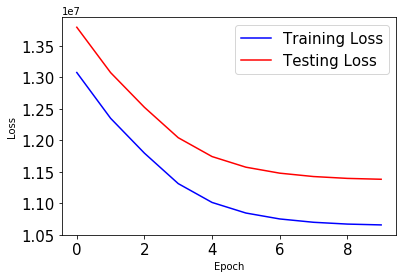

0.9418824648159677
Matrix Factorization with SGD...
Training Time: 47.41 s


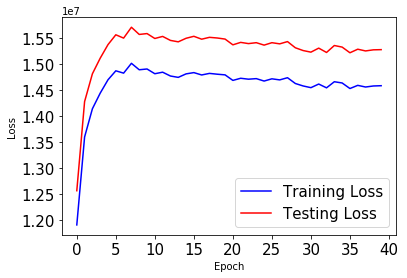

0.9582748383927182
Current number of latent features: 4
Matrix Factorization with ALS...
Training Time: 2.20 s


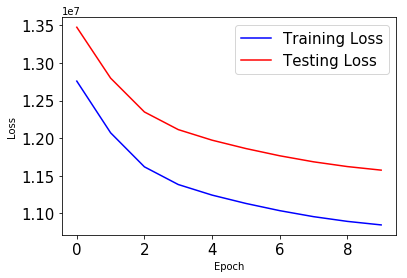

0.937354847162084
Matrix Factorization with SGD...
Training Time: 47.71 s


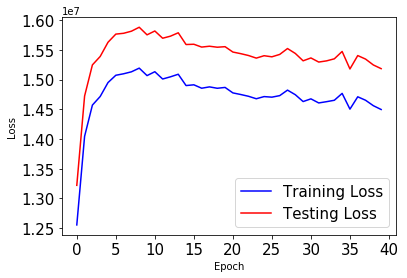

0.9639059460658019
Current number of latent features: 5
Matrix Factorization with ALS...
Training Time: 2.26 s


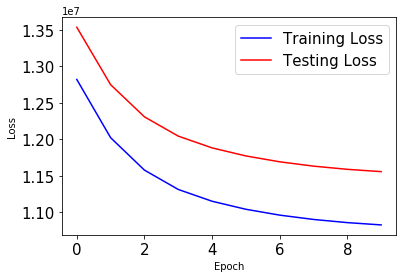

0.9476264501443831
Matrix Factorization with SGD...
Training Time: 47.88 s


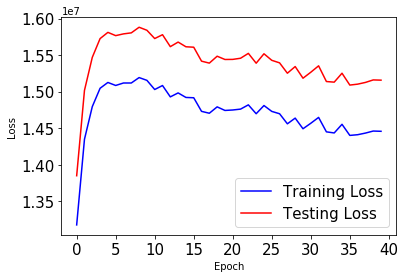

0.9543723825713613
Current number of latent features: 6
Matrix Factorization with ALS...
Training Time: 2.61 s


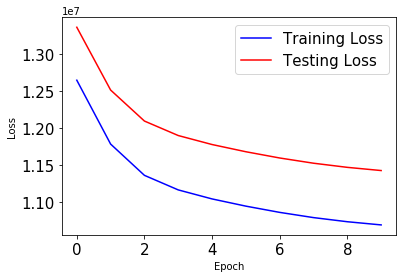

0.9479751164633765
Matrix Factorization with SGD...
Training Time: 48.01 s


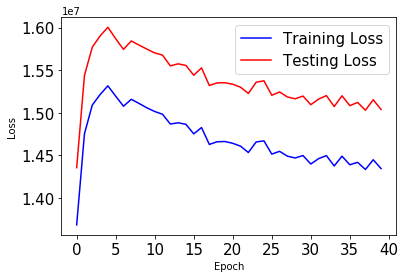

0.9459239905113882
Current number of latent features: 7
Matrix Factorization with ALS...
Training Time: 2.64 s


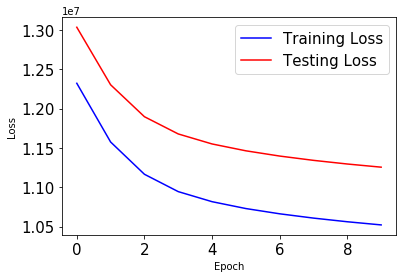

0.9520752573638241
Matrix Factorization with SGD...
Training Time: 47.15 s


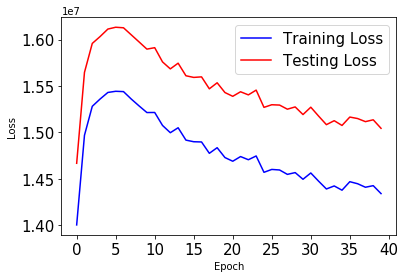

0.9536464775679562
Current number of latent features: 8
Matrix Factorization with ALS...
Training Time: 2.64 s


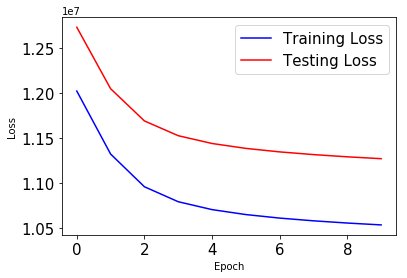

0.9611949225475342
Matrix Factorization with SGD...
Training Time: 46.56 s


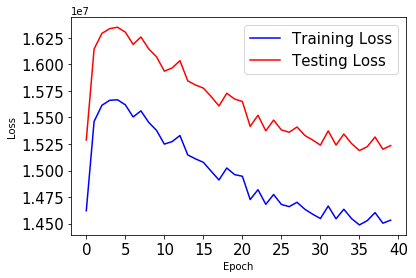

0.9515617479448895
Current number of latent features: 9
Matrix Factorization with ALS...
Training Time: 2.68 s


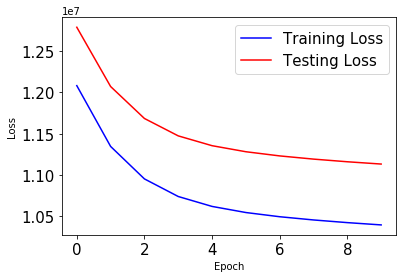

0.9602188219646011
Matrix Factorization with SGD...
Training Time: 46.84 s


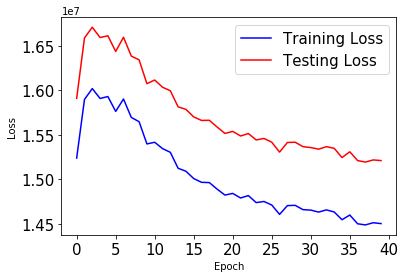

0.9481817015517874
Current number of latent features: 10
Matrix Factorization with ALS...
Training Time: 2.86 s


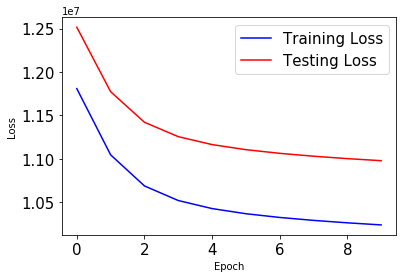

0.9716522134160007
Matrix Factorization with SGD...
Training Time: 48.20 s


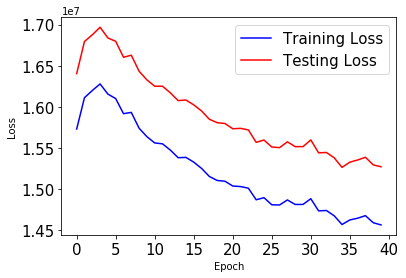

0.9533930142739864
Current number of latent features: 11
Matrix Factorization with ALS...
Training Time: 4.38 s


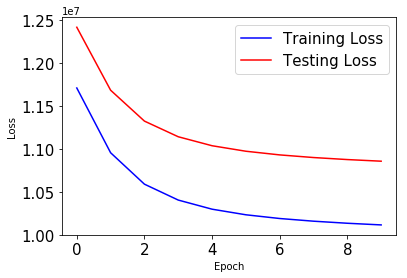

0.9808215434072255
Matrix Factorization with SGD...
Training Time: 47.96 s


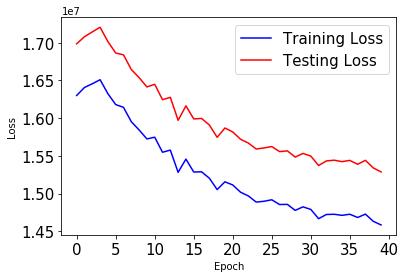

0.957020312456839
Current number of latent features: 12
Matrix Factorization with ALS...
Training Time: 2.93 s


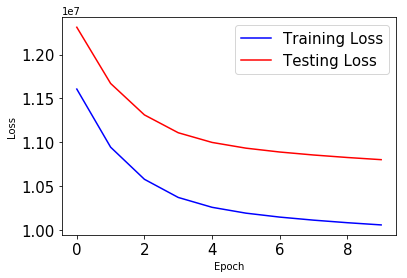

0.9829871937063832
Matrix Factorization with SGD...
Training Time: 46.19 s


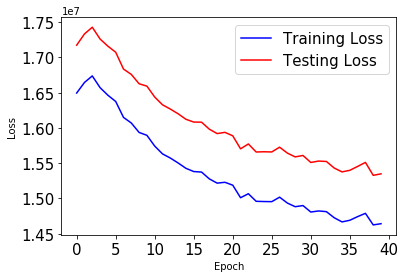

0.9526758155856854
Current number of latent features: 13
Matrix Factorization with ALS...
Training Time: 3.24 s


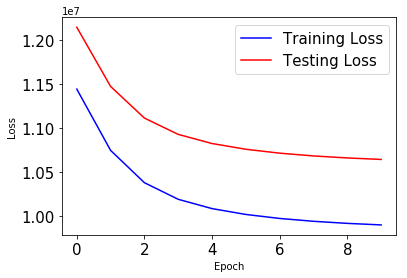

0.9830032418806274
Matrix Factorization with SGD...
Training Time: 46.80 s


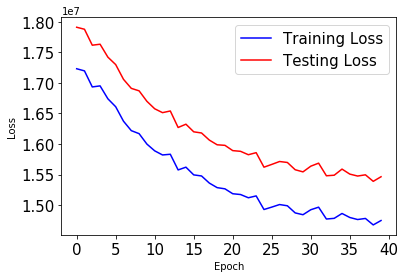

0.9435704423131428
Current number of latent features: 14
Matrix Factorization with ALS...
Training Time: 3.28 s


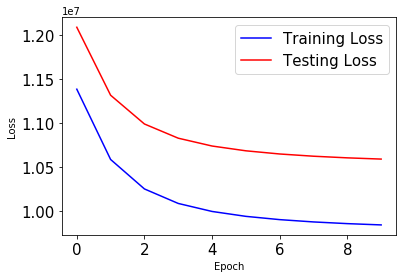

0.9908752087026012
Matrix Factorization with SGD...
Training Time: 49.26 s


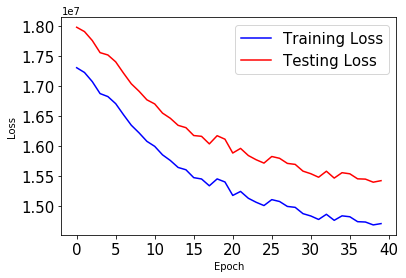

0.9445995662779878
Current number of latent features: 15
Matrix Factorization with ALS...
Training Time: 3.44 s


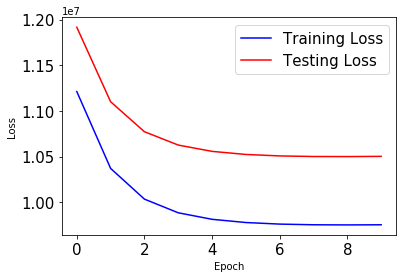

1.0018597208831674
Matrix Factorization with SGD...
Training Time: 47.68 s


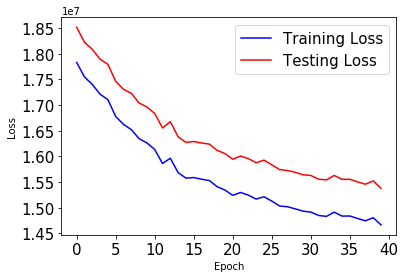

0.9477593995019716


In [8]:
K = 20 # latent features

if __name__ == '__main__':
    X_train, X_test = load_dataset(TRAIN_DATA_FILE, TEST_DATA_FILE)
    
    als_acc = []
    sgd_acc = []
    
    xticks = []
    for k in range(3, 16):
        print('Current number of latent features: {}'.format(k))
        als_rmse = ALS(X_train, X_test, n_latent_features=k, max_epoch=10)
        als_acc.append(als_rmse)
        print(als_rmse)
        sgd_rmse = SGD(X_train, X_test, n_latent_features=k, max_epoch=40)
        sgd_acc.append(sgd_rmse)
        print(sgd_rmse)
        xticks.append(k)

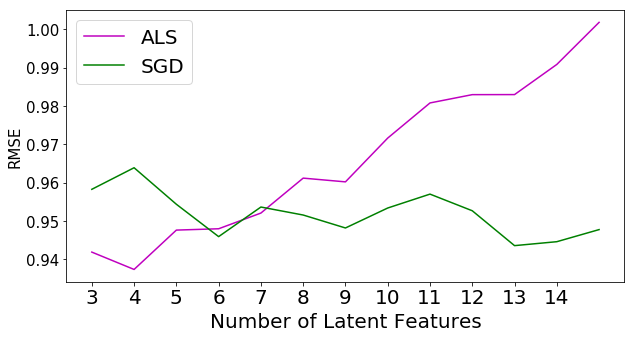

In [16]:
fig,ax = plt.subplots(figsize=(10,5))
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks)
plt.xticks(np.arange(12), xticks, fontsize=20)
plt.yticks(fontsize=15)
plt.plot(als_acc, label="ALS", color="m")
plt.plot(sgd_acc, label="SGD", color="g")
plt.xlabel('Number of Latent Features', fontsize=20)
plt.ylabel('RMSE', fontsize=15)
plt.legend(fontsize=20)
plt.savefig('./report/result.png')
plt.show()